In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, auc, roc_auc_score
from tqdm import tqdm, tqdm_notebook
import gc

In [2]:
pth = '../input/datathon-belcorp-prueba/'

maestro_consultora = pd.read_csv(pth+'maestro_consultora.csv').iloc[:, 1:]
maestro_consultora.head()

campanaingreso  campanaultimopedido  IdConsultora estadocivil  \
0          200907               201915           431   Casado(a)   
1          199708               201914          2010   Casado(a)   
2          199709               201914          3513   Casado(a)   
3          201813               201911          4895   Casado(a)   
4          199711               201914          6233   Casado(a)   

   flagsupervisor  campanaprimerpedido  flagconsultoradigital  \
0               0             200907.0                      0   
1               0             199708.0                      0   
2               0             199709.0                      0   
3               0             201813.0                      0   
4               0             199711.0                      0   

   flagcorreovalidad  edad  flagcelularvalidado  
0                0.0    58                    1  
1                NaN    58                    1  
2                NaN    60                    1  
3                NaN    50                    1  
4                NaN    65                    1

In [3]:
edad, edad_labels = pd.qcut(maestro_consultora['edad'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'], retbins=True)
maestro_consultora['edad_cuartil'] = edad

In [4]:
consultora_filter = pd.get_dummies(maestro_consultora[
    ['IdConsultora', 'campanaingreso', 'campanaultimopedido', 'campanaprimerpedido', 'edad_cuartil', 'flagsupervisor']
])
consultora_filter.head()

IdConsultora  campanaingreso  campanaultimopedido  campanaprimerpedido  \
0           431          200907               201915             200907.0   
1          2010          199708               201914             199708.0   
2          3513          199709               201914             199709.0   
3          4895          201813               201911             201813.0   
4          6233          199711               201914             199711.0   

   flagsupervisor  edad_cuartil_Q1  edad_cuartil_Q2  edad_cuartil_Q3  \
0               0                0                0                0   
1               0                0                0                0   
2               0                0                0                0   
3               0                0                0                0   
4               0                0                0                0   

   edad_cuartil_Q4  
0                1  
1                1  
2                1  
3                1  
4                1

In [5]:
maestro_producto = pd.read_csv(pth+'maestro_producto.csv').iloc[:, 1:]
maestro_producto.head()

idproducto  codigounidadnegocio unidadnegocio  codigomarca   marca  \
0   200056246                   10    COSMETICOS            2   ESIKA   
1   200089626                   10    COSMETICOS            2   ESIKA   
2   200095496                   10    COSMETICOS            2   ESIKA   
3   210089216                   50         APOYO            2   ESIKA   
4   200090369                   10    COSMETICOS            3  CYZONE   

  codigocategoria           categoria codigotipo  \
0              01          FRAGANCIAS        001   
1              04    CUIDADO PERSONAL        035   
2              01          FRAGANCIAS        001   
3              72  PROMOCION USUARIOS        553   
4              02          MAQUILLAJE        027   

                                          tipo  
0  FRAGANCIAS/DAMAS/COLONIA Y O EAU DE TOILETE  
1          CUIDADO PERSONAL/TALCOS/ESPECIFICOS  
2  FRAGANCIAS/DAMAS/COLONIA Y O EAU DE TOILETE  
3   PROMOCION USUARIOS/HOGAR/BLOQUE MAQUILLAJE  
4          MAQUILLAJE/PARA LABIOS/LAPIZ LABIAL

In [6]:
venta_campaña = pd.read_csv(pth+'dtt_fvta_cl.csv')
venta_campaña.head()

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


campana  idconsultora  codigotipooferta  descuento   ahorro  \
0   201807        544706                 1        0.0   7990.0   
1   201807        638877                 1        0.0   3800.0   
2   201807        186016                 1        0.0   3800.0   
3   201807        579940                 1        0.0  32748.0   
4   201807        342158                 1        0.0  17272.0   

  canalingresoproducto  idproducto  codigopalancapersonalizacion  \
0                  NaN   200091158                          12.0   
1                  WEB   200091762                        1111.0   
2                  APP   200091762                          42.0   
3                  WEB   200091762                          12.0   
4                  WEB   200091762                          12.0   

  palancapersonalizacion  preciocatalogo  ... realanulmnneto  realdevmnneto  \
0                    NaN          5495.0  ...            0.0            0.0   
1                    NaN          7690.0  ...            0.0            0.0   
2                    NaN          7690.0  ...            0.0            0.0   
3                    NaN          6032.0  ...            0.0            0.0   
4                    NaN          7172.0  ...            0.0            0.0   

   realuuanuladas  realuudevueltas  realuufaltantes  realuuvendidas  \
0               0                0                0               2   
1               0                0                0               1   
2               0                0                0               1   
3               0                0                0               6   
4               0                0                0               4   

   realvtamnfaltneto  realvtamnneto  realvtamncatalogo  realvtamnfaltcatalogo  
0                0.0         9236.0            10990.0                    0.0  
1                0.0         6462.0             7690.0                    0.0  
2                0.0         6462.0             7690.0                    0.0  
3                0.0        30414.0            36192.0                    0.0  
4                0.0        24108.0            28688.0                    0.0  

[5 rows x 21 columns]

In [7]:
campaña_consultora = pd.read_csv(pth+'campana_consultora.csv').iloc[:,1:]
campaña_consultora = campaña_consultora.sort_values(by=['IdConsultora', 'campana'])
campaña_consultora.head()

campana  IdConsultora  Flagpasopedido  flagactiva  \
232      201807           125               0           1   
172361   201808           125               0           0   
320095   201809           125               0           0   
314240   201810           125               0           0   
526321   201811           125               0           0   

        flagpasopedidocuidadopersonal  flagpasopedidomaquillaje  \
232                               0.0                       0.0   
172361                            0.0                       0.0   
320095                            0.0                       0.0   
314240                            0.0                       0.0   
526321                            0.0                       0.0   

        flagpasopedidotratamientocorporal  flagpasopedidotratamientofacial  \
232                                   0.0                              0.0   
172361                                0.0                              0.0   
320095                                0.0                              0.0   
314240                                0.0                              0.0   
526321                                0.0                              0.0   

        flagpedidoanulado  flagpasopedidofragancias  ... codigocanalorigen  \
232                   0.0                       0.0  ...               NaN   
172361                0.0                       0.0  ...               NaN   
320095                0.0                       0.0  ...               NaN   
314240                0.0                       0.0  ...               NaN   
526321                0.0                       0.0  ...               NaN   

        evaluacion_nuevas segmentacion flagpasopedidoweb  cantidadlogueos  \
232                   Est       Nivel2               0.0              NaN   
172361                Est       Nivel2               0.0              NaN   
320095                Est       Nivel2               0.0              NaN   
314240                Est       Nivel2               0.0              NaN   
526321                Est       Nivel2               0.0              NaN   

        flagdispositivo  flagdigital  flagofertadigital  flagsuscripcion  \
232                   0          NaN                0.0                0   
172361                0          NaN                0.0                0   
320095                0          NaN                0.0                0   
314240                0          NaN                0.0                0   
526321                0          NaN                0.0                0   

                           geografia  
232     13 STGO. / VI?A DEL MAR / VA  
172361  13 STGO. / VI?A DEL MAR / VA  
320095  13 STGO. / VI?A DEL MAR / VA  
314240  13 STGO. / VI?A DEL MAR / VA  
526321  13 STGO. / VI?A DEL MAR / VA  

[5 rows x 21 columns]

In [8]:
campaña_consultora = campaña_consultora.merge(consultora_filter[['IdConsultora', 'campanaultimopedido', 
                                                                 'flagsupervisor',
                                                                 'edad_cuartil_Q1', 'edad_cuartil_Q2', 
                                                                 'edad_cuartil_Q3', 'edad_cuartil_Q4']], 
                                              on='IdConsultora', how='left')
campaña_consultora.dropna(subset=['campanaultimopedido'], inplace=True)

In [9]:
campaña_consultora['diff_ultimopedido'] = campaña_consultora['campanaultimopedido'] - campaña_consultora['campana']

In [10]:
campaña_agg1 = pd.DataFrame(
    venta_campaña.groupby(
        ['idconsultora', 'campana']
    )['ahorro', 'realvtamncatalogo', 'realvtamnneto', 'realanulmnneto', 'realdevmnneto', 'realuuanuladas', 
      'realuudevueltas', 'realuufaltantes', 'realuuvendidas', 'realvtamnfaltneto'].sum()
).reset_index()

In [11]:
campaña_agg1.rename(columns={'idconsultora': 'IdConsultora'}, inplace=True)
campaña_agg1.head()

IdConsultora  campana   ahorro  realvtamncatalogo  realvtamnneto  \
0           202   201807  16379.0            35710.0        25022.0   
1           202   201810  19302.0            57680.0        39439.0   
2           202   201812  21338.0            52930.0        38142.0   
3           202   201813   8522.0            45810.0        29975.0   
4           202   201814  14378.0            51910.0        37335.0   

   realanulmnneto  realdevmnneto  realuuanuladas  realuudevueltas  \
0             0.0            0.0               0                0   
1             0.0            0.0               0                0   
2             0.0            0.0               0                0   
3             0.0            0.0               0                0   
4             0.0            0.0               0                0   

   realuufaltantes  realuuvendidas  realvtamnfaltneto  
0                0              13                0.0  
1                0              17                0.0  
2                0               7                0.0  
3                0              10                0.0  
4                0              12                0.0

In [12]:
campaña_agg1.columns = ['IdConsultora', 'campana', 'ahorro_sum', 'realvtamncatalogo_sum',
       'realvtamnneto_sum', 'realanulmnneto_sum', 'realdevmnneto_sum', 'realuuanuladas_sum',
       'realuudevueltas_sum', 'realuufaltantes_sum', 'realuuvendidas_sum',
       'realvtamnfaltneto_sum']
campaña_agg1.columns

Index(['IdConsultora', 'campana', 'ahorro_sum', 'realvtamncatalogo_sum',
       'realvtamnneto_sum', 'realanulmnneto_sum', 'realdevmnneto_sum',
       'realuuanuladas_sum', 'realuudevueltas_sum', 'realuufaltantes_sum',
       'realuuvendidas_sum', 'realvtamnfaltneto_sum'],
      dtype='object')

In [13]:
campaña_agg2 = pd.DataFrame(
    venta_campaña.groupby(
        ['idconsultora', 'campana']
    )['ahorro', 'realvtamncatalogo', 'realvtamnneto', 'realanulmnneto', 'realdevmnneto', 'realuuanuladas', 
      'realuudevueltas', 'realuufaltantes', 'realuuvendidas', 'realvtamnfaltneto'].mean()
).reset_index()

In [14]:
campaña_agg2.rename(columns={'idconsultora': 'IdConsultora'}, inplace=True)
campaña_agg2.head()

IdConsultora  campana       ahorro  realvtamncatalogo  realvtamnneto  \
0           202   201807  1364.916667        2975.833333    2085.166667   
1           202   201810  1206.375000        3605.000000    2464.937500   
2           202   201812  3048.285714        7561.428571    5448.857143   
3           202   201813   946.888889        5090.000000    3330.555556   
4           202   201814  1597.555556        5767.777778    4148.333333   

   realanulmnneto  realdevmnneto  realuuanuladas  realuudevueltas  \
0             0.0            0.0             0.0              0.0   
1             0.0            0.0             0.0              0.0   
2             0.0            0.0             0.0              0.0   
3             0.0            0.0             0.0              0.0   
4             0.0            0.0             0.0              0.0   

   realuufaltantes  realuuvendidas  realvtamnfaltneto  
0              0.0        1.083333                0.0  
1              0.0        1.062500                0.0  
2              0.0        1.000000                0.0  
3              0.0        1.111111                0.0  
4              0.0        1.333333                0.0

In [15]:
campaña_agg2.columns = ['IdConsultora', 'campana', 'ahorro_mean', 'realvtamncatalogo_mean',
       'realvtamnneto_mean', 'realanulmnneto_mean', 'realdevmnneto_mean', 'realuuanuladas_mean',
       'realuudevueltas_mean', 'realuufaltantes_mean', 'realuuvendidas_mean',
       'realvtamnfaltneto_mean']
campaña_agg2.columns

Index(['IdConsultora', 'campana', 'ahorro_mean', 'realvtamncatalogo_mean',
       'realvtamnneto_mean', 'realanulmnneto_mean', 'realdevmnneto_mean',
       'realuuanuladas_mean', 'realuudevueltas_mean', 'realuufaltantes_mean',
       'realuuvendidas_mean', 'realvtamnfaltneto_mean'],
      dtype='object')

In [16]:
campaña_agg = campaña_agg1.merge(campaña_agg2, on=['IdConsultora', 'campana'])
campaña_agg.head()

IdConsultora  campana  ahorro_sum  realvtamncatalogo_sum  \
0           202   201807     16379.0                35710.0   
1           202   201810     19302.0                57680.0   
2           202   201812     21338.0                52930.0   
3           202   201813      8522.0                45810.0   
4           202   201814     14378.0                51910.0   

   realvtamnneto_sum  realanulmnneto_sum  realdevmnneto_sum  \
0            25022.0                 0.0                0.0   
1            39439.0                 0.0                0.0   
2            38142.0                 0.0                0.0   
3            29975.0                 0.0                0.0   
4            37335.0                 0.0                0.0   

   realuuanuladas_sum  realuudevueltas_sum  realuufaltantes_sum  ...  \
0                   0                    0                    0  ...   
1                   0                    0                    0  ...   
2                   0                    0                    0  ...   
3                   0                    0                    0  ...   
4                   0                    0                    0  ...   

   ahorro_mean  realvtamncatalogo_mean  realvtamnneto_mean  \
0  1364.916667             2975.833333         2085.166667   
1  1206.375000             3605.000000         2464.937500   
2  3048.285714             7561.428571         5448.857143   
3   946.888889             5090.000000         3330.555556   
4  1597.555556             5767.777778         4148.333333   

   realanulmnneto_mean  realdevmnneto_mean  realuuanuladas_mean  \
0                  0.0                 0.0                  0.0   
1                  0.0                 0.0                  0.0   
2                  0.0                 0.0                  0.0   
3                  0.0                 0.0                  0.0   
4                  0.0                 0.0                  0.0   

   realuudevueltas_mean  realuufaltantes_mean  realuuvendidas_mean  \
0                   0.0                   0.0             1.083333   
1                   0.0                   0.0             1.062500   
2                   0.0                   0.0             1.000000   
3                   0.0                   0.0             1.111111   
4                   0.0                   0.0             1.333333   

   realvtamnfaltneto_mean  
0                     0.0  
1                     0.0  
2                     0.0  
3                     0.0  
4                     0.0  

[5 rows x 22 columns]

In [17]:
set_a = set(campaña_agg['IdConsultora'].unique().tolist()) 
set_b = set(campaña_consultora['IdConsultora'].unique().tolist())
inter_ = set_a & set_b

In [18]:
campaña_merge = campaña_consultora.merge(campaña_agg, on=['IdConsultora', 'campana'], how='left')
campaña_merge = campaña_merge.sort_values(by=['IdConsultora', 'campana'])
campaña_merge = campaña_merge.drop(['codigocanalorigen'], axis=1)
campaña_merge.fillna(0, inplace=True)
campaña_merge.head()

campana  IdConsultora  Flagpasopedido  flagactiva  \
0   201807           125               0           1   
1   201808           125               0           0   
2   201809           125               0           0   
3   201810           125               0           0   
4   201811           125               0           0   

   flagpasopedidocuidadopersonal  flagpasopedidomaquillaje  \
0                            0.0                       0.0   
1                            0.0                       0.0   
2                            0.0                       0.0   
3                            0.0                       0.0   
4                            0.0                       0.0   

   flagpasopedidotratamientocorporal  flagpasopedidotratamientofacial  \
0                                0.0                              0.0   
1                                0.0                              0.0   
2                                0.0                              0.0   
3                                0.0                              0.0   
4                                0.0                              0.0   

   flagpedidoanulado  flagpasopedidofragancias  ... ahorro_mean  \
0                0.0                       0.0  ...         0.0   
1                0.0                       0.0  ...         0.0   
2                0.0                       0.0  ...         0.0   
3                0.0                       0.0  ...         0.0   
4                0.0                       0.0  ...         0.0   

  realvtamncatalogo_mean realvtamnneto_mean  realanulmnneto_mean  \
0                    0.0                0.0                  0.0   
1                    0.0                0.0                  0.0   
2                    0.0                0.0                  0.0   
3                    0.0                0.0                  0.0   
4                    0.0                0.0                  0.0   

   realdevmnneto_mean  realuuanuladas_mean  realuudevueltas_mean  \
0                 0.0                  0.0                   0.0   
1                 0.0                  0.0                   0.0   
2                 0.0                  0.0                   0.0   
3                 0.0                  0.0                   0.0   
4                 0.0                  0.0                   0.0   

   realuufaltantes_mean  realuuvendidas_mean realvtamnfaltneto_mean  
0                   0.0                  0.0                    0.0  
1                   0.0                  0.0                    0.0  
2                   0.0                  0.0                    0.0  
3                   0.0                  0.0                    0.0  
4                   0.0                  0.0                    0.0  

[5 rows x 47 columns]

In [19]:
campaña_merge['Flag_shift'] = campaña_merge.groupby('IdConsultora')['Flagpasopedido'].shift(-1)
campaña_merge = campaña_merge.select_dtypes(exclude=['object'])

In [20]:
df_val = campaña_merge[campaña_merge['Flag_shift'].isnull()].set_index(['IdConsultora', 'campana'])
df_model = campaña_merge[campaña_merge['Flag_shift'].notna()].set_index(['IdConsultora', 'campana'])

In [21]:
X = df_model.drop(['Flag_shift', 'campanaultimopedido', 'flagdigital', 'Flagpasopedido', 'flagpedidoanulado'], axis=1)
y = df_model['Flag_shift']

In [22]:
X.columns

Index(['flagactiva', 'flagpasopedidocuidadopersonal',
       'flagpasopedidomaquillaje', 'flagpasopedidotratamientocorporal',
       'flagpasopedidotratamientofacial', 'flagpasopedidofragancias',
       'flagpasopedidoweb', 'cantidadlogueos', 'flagdispositivo',
       'flagofertadigital', 'flagsuscripcion', 'flagsupervisor',
       'edad_cuartil_Q1', 'edad_cuartil_Q2', 'edad_cuartil_Q3',
       'edad_cuartil_Q4', 'diff_ultimopedido', 'ahorro_sum',
       'realvtamncatalogo_sum', 'realvtamnneto_sum', 'realanulmnneto_sum',
       'realdevmnneto_sum', 'realuuanuladas_sum', 'realuudevueltas_sum',
       'realuufaltantes_sum', 'realuuvendidas_sum', 'realvtamnfaltneto_sum',
       'ahorro_mean', 'realvtamncatalogo_mean', 'realvtamnneto_mean',
       'realanulmnneto_mean', 'realdevmnneto_mean', 'realuuanuladas_mean',
       'realuudevueltas_mean', 'realuufaltantes_mean', 'realuuvendidas_mean',
       'realvtamnfaltneto_mean'],
      dtype='object')

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
lgbm_class = lgb.LGBMClassifier(n_estimators=1000, learning_rate=0.01, n_jobs=-1, random_state=1234)
lgbm_class.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.01, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
               random_state=1234, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [25]:
predict_lgbm = lgbm_class.predict(X_test)
accuracy_score(y_test, predict_lgbm)

0.8820947073591943

In [26]:
predict_probs = lgbm_class.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, predict_probs)
auc

0.9175909403729048

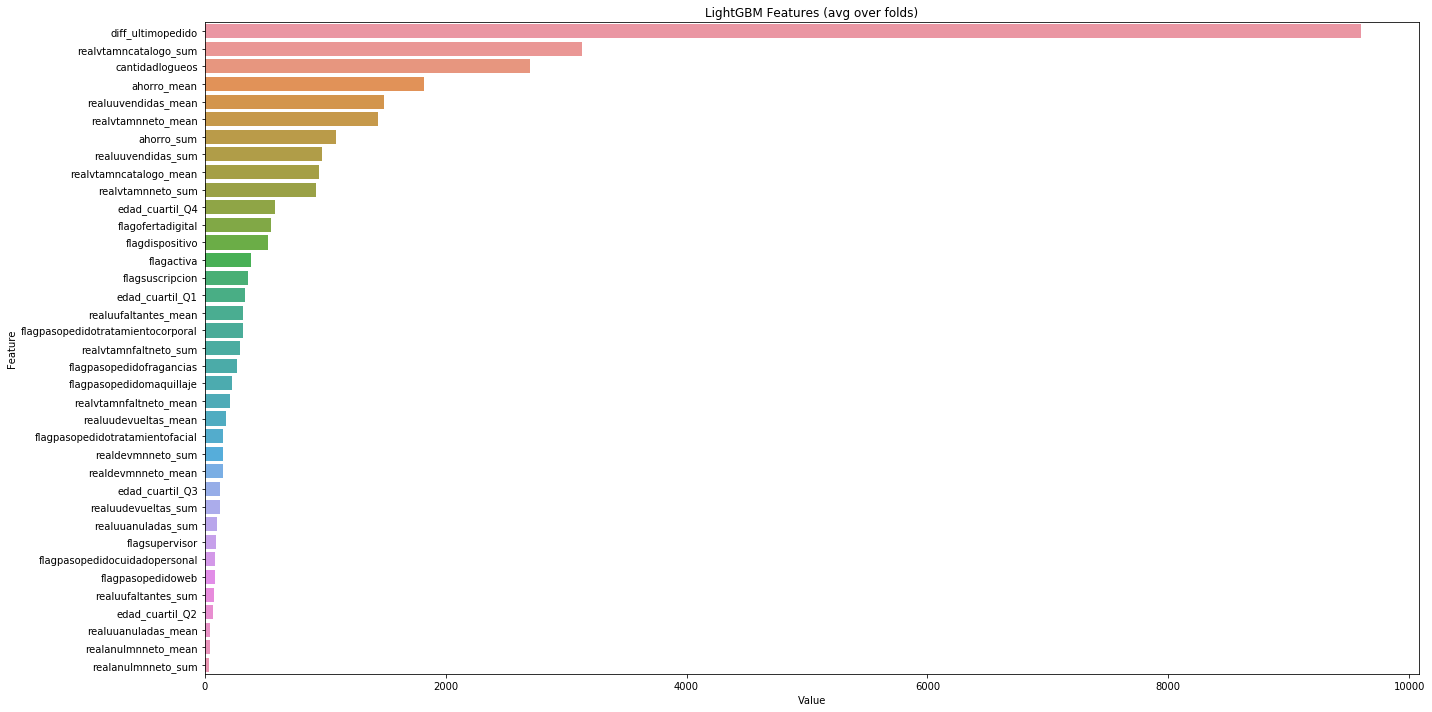

In [27]:
feature_imp = pd.DataFrame(sorted(zip(lgbm_class.feature_importances_, X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [28]:
df_val.columns

Index(['Flagpasopedido', 'flagactiva', 'flagpasopedidocuidadopersonal',
       'flagpasopedidomaquillaje', 'flagpasopedidotratamientocorporal',
       'flagpasopedidotratamientofacial', 'flagpedidoanulado',
       'flagpasopedidofragancias', 'flagpasopedidoweb', 'cantidadlogueos',
       'flagdispositivo', 'flagdigital', 'flagofertadigital',
       'flagsuscripcion', 'campanaultimopedido', 'flagsupervisor',
       'edad_cuartil_Q1', 'edad_cuartil_Q2', 'edad_cuartil_Q3',
       'edad_cuartil_Q4', 'diff_ultimopedido', 'ahorro_sum',
       'realvtamncatalogo_sum', 'realvtamnneto_sum', 'realanulmnneto_sum',
       'realdevmnneto_sum', 'realuuanuladas_sum', 'realuudevueltas_sum',
       'realuufaltantes_sum', 'realuuvendidas_sum', 'realvtamnfaltneto_sum',
       'ahorro_mean', 'realvtamncatalogo_mean', 'realvtamnneto_mean',
       'realanulmnneto_mean', 'realdevmnneto_mean', 'realuuanuladas_mean',
       'realuudevueltas_mean', 'realuufaltantes_mean', 'realuuvendidas_mean',
       'realvtam

In [29]:
predict_bel = pd.read_csv(pth+'predict_submission.csv')

In [30]:
df_sub_tmp = df_val.loc[predict_bel['idconsultora'].tolist()].drop('Flag_shift', axis=1)

In [31]:
df_sub_tmp['Flag_shift'] = lgbm_class.predict_proba(df_sub_tmp[X_train.columns])[:, 1]
df_sub_tmp.head()

Flagpasopedido  flagactiva  \
IdConsultora campana                               
202          201906                1           1   
243          201906                1           1   
274          201906                1           1   
293          201906                1           1   
431          201906                1           1   

                      flagpasopedidocuidadopersonal  flagpasopedidomaquillaje  \
IdConsultora campana                                                            
202          201906                             1.0                       1.0   
243          201906                             1.0                       1.0   
274          201906                             1.0                       1.0   
293          201906                             1.0                       1.0   
431          201906                             1.0                       1.0   

                      flagpasopedidotratamientocorporal  \
IdConsultora campana                                      
202          201906                                 1.0   
243          201906                                 1.0   
274          201906                                 1.0   
293          201906                                 1.0   
431          201906                                 0.0   

                      flagpasopedidotratamientofacial  flagpedidoanulado  \
IdConsultora campana                                                       
202          201906                               1.0                0.0   
243          201906                               0.0                0.0   
274          201906                               1.0                0.0   
293          201906                               1.0                0.0   
431          201906                               1.0                0.0   

                      flagpasopedidofragancias  flagpasopedidoweb  \
IdConsultora campana                                                
202          201906                        0.0                1.0   
243          201906                        1.0                1.0   
274          201906                        1.0                1.0   
293          201906                        1.0                1.0   
431          201906                        1.0                1.0   

                      cantidadlogueos  ...  realvtamncatalogo_mean  \
IdConsultora campana                   ...                           
202          201906               2.0  ...             6965.000000   
243          201906               5.0  ...             4770.288462   
274          201906               4.0  ...             6362.318841   
293          201906              11.0  ...             8295.327273   
431          201906               2.0  ...             4908.333333   

                      realvtamnneto_mean  realanulmnneto_mean  \
IdConsultora campana                                            
202          201906          4977.375000                  0.0   
243          201906          3162.134615                  0.0   
274          201906          3715.811594                  0.0   
293          201906          5768.236364                  0.0   
431          201906          3572.666667                  0.0   

                      realdevmnneto_mean  realuuanuladas_mean  \
IdConsultora campana                                            
202          201906             0.000000                  0.0   
243          201906             0.000000                  0.0   
274          201906             0.000000                  0.0   
293          201906           335.054545                  0.0   
431          201906             0.000000                  0.0   

                      realuudevueltas_mean  realuufaltantes_mean  \
IdConsultora campana                                               
202          201906               0.000000              0.000000   
243          201906               0.000000         

In [32]:
df_sub = df_sub_tmp.reset_index()[['IdConsultora', 'Flag_shift']]
df_sub = df_sub.set_index('IdConsultora').loc[predict_bel['idconsultora'].tolist()].reset_index()
df_sub.rename(columns={'IdConsultora': 'idconsultora', 'Flag_shift': 'flagpasopedido'}, inplace=True)
df_sub.head()

idconsultora  flagpasopedido
0        175391        0.881211
1        336826        0.877884
2        667498        0.000030
3        386050        0.835001
4        504579        0.934173

In [33]:
df_sub.shape, predict_bel.shape

((120895, 2), (120895, 2))

In [34]:
df_sub.to_csv('submission_01.csv', encoding='utf-8', index=None)

In [35]:
del df_val, X, y, X_train, X_test

In [36]:
# Submission part 2 (completar parte 1)

In [37]:
prods = pd.read_csv(pth+'maestro_producto.csv',index_col=0)
cnslt = pd.read_csv(pth+'maestro_consultora.csv',index_col=0)
camps = pd.read_csv(pth+'campana_consultora.csv',index_col=0).sort_values(by=['IdConsultora','campana']).reset_index(drop=True)
hists = pd.read_csv(pth+'dtt_fvta_cl.csv').sort_values(by=['idconsultora','campana']).reset_index(drop=True)
submt = pd.read_csv(pth+'predict_submission.csv')

/opt/conda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [38]:
aa = hists.groupby(by=['idconsultora','campana']).agg({'ahorro':['sum'],'idproducto':['count'],'realuuvendidas':['sum'],
                                                  'realvtamnfaltneto':['sum'],'realvtamnneto':['sum'],
                                                  'realvtamncatalogo':['sum'],'realvtamnfaltcatalogo':['sum']}).reset_index()
aa.columns =[x[0] for x in aa.columns]

In [39]:
camps = pd.merge(camps,aa,left_on=['IdConsultora','campana'],right_on=['idconsultora','campana'],
                 how='left').drop(columns=['idconsultora'])

In [40]:
def weighted_mean(x):
    weights = np.flip([(1/(i+2)) for i in range(len(x))])
    return np.average(x,weights=weights)

def count_last_zeros(x):
    return sum(x[-6:]==0)

def count_shifts(x):
    return(sum(np.diff(x)==1))

In [41]:
last = camps[camps['campana']==201906]
nlst = camps[camps['campana']<201906]
last[~last['IdConsultora'].isin(nlst['IdConsultora'].values)]['Flagpasopedido'].value_counts()

1    3543
Name: Flagpasopedido, dtype: int64

In [42]:
agg = {
    'Flagpasopedido':['count','sum','last','std',weighted_mean, count_last_zeros,count_shifts],
    'flagactiva':['sum','last',count_last_zeros,count_shifts],
    'flagofertadigital':['sum','last','std',weighted_mean,count_shifts],
    #'flagdigital':['sum','mean','last',weighted_mean],
    'flagdispositivo':['sum','last',weighted_mean,count_shifts],
    'cantidadlogueos':['sum','median','std','min','max','last',weighted_mean],
    'flagpasopedidoweb':['sum','last',weighted_mean,count_shifts],
    'evaluacion_nuevas':['sum','last',weighted_mean],
    'flagpasopedidofragancias':['sum','std','last',weighted_mean,count_shifts],
    'flagpasopedidotratamientofacial':['sum','std','last',weighted_mean,count_shifts],
    'flagpasopedidotratamientocorporal':['sum','std','last',weighted_mean,count_shifts],
    'flagpasopedidomaquillaje':['sum','std','last',weighted_mean,count_shifts],
    'flagpasopedidocuidadopersonal':['sum','std','last',weighted_mean,count_shifts],
    'agg3':['sum','last','std',weighted_mean, count_last_zeros,count_shifts],
    'flagcelularvalidado':['last'],
    'edad':['last'],
    'antiguedad':['last'],
    'estadocivil':['last'],
    'flagsuscripcion':['last'],
    'ahorro':['sum','last','median','max','std', weighted_mean],
    'idproducto':['sum','last','median','max','std', weighted_mean],
    'realuuvendidas':['sum','last','median','max','std', weighted_mean],
    'realvtamnfaltneto':['sum','last','median','max','std', weighted_mean],
    'realvtamnneto':['sum','last','median','max','std', weighted_mean],
    'realvtamncatalogo':['sum','last','median','max','std', weighted_mean],
    'realvtamnfaltcatalogo':['sum','last','median','max','std', weighted_mean],
      }

In [43]:
def build_db(camps, cnslt, campana, agg, tt=True, idx = None):
    
    nlst = camps[camps['campana']<campana]
    nlst['cantidadlogueos'] = nlst['cantidadlogueos'].fillna(0)
    nlst['evaluacion_nuevas'] = nlst['evaluacion_nuevas'].str[0].map({'C':0,'E':1,'I':2})
    nlst['agg3'] = (1-nlst['flagpedidoanulado'])*nlst['Flagpasopedido']
    
    nlst = pd.merge(nlst,cnslt, on = 'IdConsultora', how = 'left')
    
    nlst['antiguedad'] = ((nlst['campana']-nlst['campanaprimerpedido'])//100)*18+(nlst['campana']%100-nlst['campanaprimerpedido']%100).clip(-np.inf,420)
    nlst['estadocivil'] = nlst['estadocivil'].map({'Casado(a)':1, 'Conviviente':1, 'Soltero(a)':2}).fillna(0)
    
    if not tt:
        nlst = nlst[nlst['campana']>201807].reset_index(drop=True)
    
    train = nlst.groupby('IdConsultora').agg(agg).reset_index()
    train.columns = ['IdConsultora'] + [x + '_' + y for x, y in train.columns[1:]]
    
    if tt:
        last = camps[camps['campana']==campana][['IdConsultora','Flagpasopedido']]
        df =  pd.merge(last['IdConsultora'], train,
                        on = 'IdConsultora', how = 'left').rename(columns={'IdConsultora':'idconsultora'})
        y = last['Flagpasopedido'].reset_index(drop=True)
    else:
        last = idx
        df =  pd.merge(last['idconsultora'], train, left_on = 'idconsultora', right_on = 'IdConsultora',
                        how = 'left').drop(columns=['IdConsultora'])
        y=idx
        
    return df,y

In [44]:
Xa, ya = build_db(camps, cnslt, 201906, agg)
X_val, z = build_db(camps, cnslt, 201907, agg, tt=False, idx = submt)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [45]:
c2d = X_val.columns[X_val.isna().mean()>0.5]
Xa.drop(columns=c2d,inplace=True)
X_val = X_val[Xa.columns]

In [46]:
Xa.shape, X_val.shape

((85922, 106), (120895, 106))

In [47]:
Xa = Xa.reset_index(drop=True)
ya = ya.reset_index(drop=True)

In [48]:
add1 = X_val[X_val['idconsultora'].isin(cnslt[cnslt['campanaultimopedido']==201907]['IdConsultora'].values)]
Xa = pd.concat([Xa,add1],ignore_index=True)
ya = pd.concat([ya,pd.Series([1]*add1.shape[0])],ignore_index=True)

add2 = X_val[X_val['idconsultora'].isin(cnslt[cnslt['campanaultimopedido']<201907]['IdConsultora'].values)]
Xa = pd.concat([Xa,add2],ignore_index=True)
ya = pd.concat([ya,pd.Series([0]*add2.shape[0])],ignore_index=True)

del add1, add2

In [49]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

predictions=pd.DataFrame()
preds_oof_lgb = np.zeros((Xa.shape[0],))

importances=pd.DataFrame()
importances['Features']=Xa.columns[1:]
for i,(a,b) in enumerate(kf.split(Xa,ya)):
    X_tr=Xa.iloc[a,1:].values
    X_te=Xa.iloc[b,1:].values
    y_train=ya[a].values
    y_test=ya[b].values
    
    train_data=lgb.Dataset(X_tr, y_train)
    test_data=lgb.Dataset(X_te, y_test)
    
    print('---------- Training fold Nº {} ----------'.format(i+1))
    
    params = {'num_leaves': 10,
         'min_data_in_leaf': 1800,
         'objective': 'binary',
         #'colsample_bytree':0.2,
         'learning_rate': 0.02,
         'boosting': 'gbdt',
         'bagging_freq': 5,
         'bagging_fraction': 0.6,
         'feature_fraction': 0.8,
         'bagging_seed': 11,
         'random_state': 42,
         'metric': 'auc',
         'verbosity': -1,}
    
    model = lgb.train(params,train_data,num_boost_round=10000,valid_sets = [train_data, test_data],
                      verbose_eval=500,early_stopping_rounds = 500)
    
    predictions[str(i)] = model.predict(X_val.iloc[:,1:].values,num_iterations=model.best_iteration)
    preds_oof_lgb[b] = model.predict(X_te,num_iterations=model.best_iteration)
    
    name = 'importance_'+str(i)
    importances[name]=model.feature_importance()
    
    gc.collect()
    
print('ROC AUC SCORE: {}'.format(roc_auc_score(ya, preds_oof_lgb)))

---------- Training fold Nº 1 ----------
Training until validation scores don't improve for 500 rounds
[500]	training's auc: 0.962307	valid_1's auc: 0.961184
[1000]	training's auc: 0.964196	valid_1's auc: 0.961712
[1500]	training's auc: 0.96564	valid_1's auc: 0.96191
[2000]	training's auc: 0.966872	valid_1's auc: 0.961912
Early stopping, best iteration is:
[1705]	training's auc: 0.966153	valid_1's auc: 0.96194
---------- Training fold Nº 2 ----------
Training until validation scores don't improve for 500 rounds
[500]	training's auc: 0.962037	valid_1's auc: 0.962052
[1000]	training's auc: 0.964027	valid_1's auc: 0.962431
[1500]	training's auc: 0.965483	valid_1's auc: 0.962495
[2000]	training's auc: 0.966741	valid_1's auc: 0.962512
Early stopping, best iteration is:
[1623]	training's auc: 0.965813	valid_1's auc: 0.962547
---------- Training fold Nº 3 ----------
Training until validation scores don't improve for 500 rounds
[500]	training's auc: 0.96259	valid_1's auc: 0.959999
[1000]	train

In [50]:
predictions_lgb = predictions.mean(axis=1)

In [51]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

predictions=pd.DataFrame()
preds_oof_xgb = np.zeros((Xa.shape[0],))

importances_xgb= list()
for i,(a,b) in enumerate(kf.split(Xa,ya)):
    X_tr=Xa.iloc[a,1:].values
    X_te=Xa.iloc[b,1:].values
    y_train=ya[a].values
    y_test=ya[b].values
    
    dtrain = xgb.DMatrix(X_tr, y_train)
    dval = xgb.DMatrix(X_te, y_test)
    
    print('---------- Training fold Nº {} ----------'.format(i+1))
    
    params = {'tree_method': 'auto',
              'min_samples_leaf':2000,
             'learning_rate': 0.01,
             'max_leaves': 10,
             'objective': 'binary:logistic',
             'eval_metric': 'auc',
             'grow_policy':'depthwise'
    }
    
    model2 = xgb.train(params=params, dtrain=dtrain, num_boost_round=15000, evals=[(dval, "Val")],
                      verbose_eval= 100, early_stopping_rounds=400)
    
    predictions[str(i)] = model2.predict(xgb.DMatrix(X_val[Xa.columns[1:]].values))
    preds_oof_xgb[b] = model2.predict(dval)
    
    #name = 'importance_'+str(i)
    importances_xgb.append(model2.get_score(importance_type="gain"))
    
    gc.collect()
    
print('ROC AUC SCORE: {}'.format(roc_auc_score(ya, preds_oof_xgb)))

---------- Training fold Nº 1 ----------
[0]	Val-auc:0.957446
Will train until Val-auc hasn't improved in 400 rounds.
[100]	Val-auc:0.960103
[200]	Val-auc:0.960415
[300]	Val-auc:0.9608
[400]	Val-auc:0.961276
[500]	Val-auc:0.961571
[600]	Val-auc:0.961718
[700]	Val-auc:0.96183
[800]	Val-auc:0.961868
[900]	Val-auc:0.961876
[1000]	Val-auc:0.961898
[1100]	Val-auc:0.961919
[1200]	Val-auc:0.961929
[1300]	Val-auc:0.961938
[1400]	Val-auc:0.96196
[1500]	Val-auc:0.96198
[1600]	Val-auc:0.962
[1700]	Val-auc:0.961998
[1800]	Val-auc:0.961995
[1900]	Val-auc:0.961972
[2000]	Val-auc:0.961971
Stopping. Best iteration:
[1625]	Val-auc:0.962012

---------- Training fold Nº 2 ----------
[0]	Val-auc:0.957862
Will train until Val-auc hasn't improved in 400 rounds.
[100]	Val-auc:0.960667
[200]	Val-auc:0.961256
[300]	Val-auc:0.961611
[400]	Val-auc:0.961921
[500]	Val-auc:0.962104
[600]	Val-auc:0.96226
[700]	Val-auc:0.962395
[800]	Val-auc:0.96248
[900]	Val-auc:0.962498
[1000]	Val-auc:0.962512
[1100]	Val-auc:0.9625

In [52]:
predictions_xgb = predictions.mean(axis=1)

In [53]:
from catboost import CatBoostClassifier, Pool, cv
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

predictions=pd.DataFrame()
preds_oof_cat = np.zeros((Xa.shape[0],))

importances_cat=pd.DataFrame()
importances_cat['Features']=Xa.columns[1:]
for i,(a,b) in enumerate(kf.split(Xa,ya)):
    X_tr=Xa.iloc[a,1:]
    X_te=Xa.iloc[b,1:]
    y_train=ya[a]
    y_test=ya[b]
    
    print("train pool")
    trn_data = Pool(X_tr, y_train)
    #gc.collect()
    print("valid pool")
    val_data = Pool(X_te, y_test) 
    
    print('---------- Training fold Nº {} ----------'.format(i+1))
    
    cat_params = {
                'n_estimators':5000,
                'learning_rate': 0.07,
                'eval_metric':'AUC',
                'loss_function':'Logloss',
                'random_seed':42,
                'metric_period':500,
                'od_wait':500,
                'task_type':'CPU',
                'depth': 15,
                } 
    
    model3 = CatBoostClassifier(iterations=5000,
                                   random_state=10,
                                   learning_rate=0.02,
                                   task_type = "CPU",
                                   eval_metric= 'AUC',
                                   early_stopping_rounds = 200,
                                  )
    
    model3.fit(trn_data,
          use_best_model=True,
          eval_set=val_data,
          verbose=False,
          plot=True)
    
    predictions[str(i)] = model3.predict_proba(X_val.iloc[:,1:].values)[:,1]
    preds_oof_cat[b] = model3.predict_proba(X_te)[:,1] 
    
    name = 'importance_'+str(i)
    importances_cat[name]=model3.get_feature_importance()
    
    gc.collect()
    
print('ROC AUC SCORE: {}'.format(roc_auc_score(ya, preds_oof_cat)))

train pool
valid pool
---------- Training fold Nº 1 ----------


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

train pool
valid pool
---------- Training fold Nº 2 ----------


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

train pool
valid pool
---------- Training fold Nº 3 ----------


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

train pool
valid pool
---------- Training fold Nº 4 ----------


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

train pool
valid pool
---------- Training fold Nº 5 ----------


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

ROC AUC SCORE: 0.961658873080206


In [54]:
predictions_cat = predictions.mean(axis=1)

In [55]:
submt['flagpasopedido'] = pd.concat([predictions_cat,predictions_xgb,predictions_lgb],axis=1).mean(axis=1).values

In [56]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression()
logit.fit(pd.concat([pd.Series(x) for x in [preds_oof_lgb,preds_oof_xgb,preds_oof_cat]],axis=1),ya)
logit.coef_

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([[1.53220638, 1.85225035, 3.24082497]])

In [57]:
submt['flagpasopedido'] = logit.predict_proba(pd.concat([predictions_lgb,predictions_xgb,predictions_cat],axis=1).values)[:,1]

In [58]:
submt['flagpasopedido'] = np.where(submt['idconsultora'].isin(cnslt[cnslt['campanaultimopedido']<201906]['IdConsultora'].values),0,submt['flagpasopedido'])
submt['flagpasopedido'] = np.where(submt['idconsultora'].isin(cnslt[cnslt['campanaultimopedido']==201907]['IdConsultora'].values),1,submt['flagpasopedido'])

In [59]:
submt.to_csv('submission_02.csv',index=None, encoding='utf-8',sep=',')

In [60]:
# Parte 3 (logit)

In [61]:
submt = pd.read_csv(pth+'predict_submission.csv')

In [62]:
indx = pd.MultiIndex.from_tuples(list(zip(camps['campana'],camps['IdConsultora'])),names=['index','idconsultora'])
hist = pd.DataFrame(camps['Flagpasopedido'].values, index=indx).unstack().T.reset_index().iloc[:,1:]

In [63]:
X = hist[(hist.iloc[:,1:-1].isna().mean(axis=1)<1) & (~hist.iloc[:,-1].isna())].iloc[:,:-1]
y = hist[(hist.iloc[:,1:-1].isna().mean(axis=1)<1) & (~hist.iloc[:,-1].isna())].iloc[:,-1]

In [64]:
from sklearn.linear_model import LinearRegression

logit = LinearRegression()
logit.fit(X[X[[201807,201903,201904]].isna().sum(axis=1)<1].iloc[:,1:].fillna(0),y[X[[201807,201903,201904]].isna().sum(axis=1)<1])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [65]:
logit.coef_

array([-0.00594217,  0.00482307,  0.01687138,  0.01726069,  0.0015639 ,
        0.01900417,  0.01044116,  0.02557742,  0.02390922,  0.04572593,
        0.04330941, -0.0066949 ,  0.01862455,  0.03768668,  0.03279739,
        0.18540844,  0.39559034])

In [66]:
def weighted_mean(x):
    weights = [0, -0.00594217,  0.00482307,  0.01687138,  0.01726069,  0.0015639 ,
        0.01900417,  0.01044116,  0.02557742,  0.02390922,  0.04572593,
        0.04330941, -0.0066949 ,  0.01862455,  0.03768668,  0.03279739,
        0.18540844,  0.39559034][-len(x):]
    return np.average(x,weights=weights)

In [67]:
# Simple weighted mean approach
from sklearn.metrics import roc_auc_score

lst = camps['IdConsultora'].isin(camps[camps['campana']<201906]['IdConsultora'])

res = pd.merge(camps[(camps['campana']==201906)][['IdConsultora','Flagpasopedido']],
         camps[(camps['campana']!=201906)].groupby('IdConsultora').agg({'Flagpasopedido':weighted_mean}).reset_index(),
         on = 'IdConsultora', how = 'left').iloc[:,-1].fillna(1).values
roc_auc_score(camps[camps['campana']==201906]['Flagpasopedido'].values, res)

0.8837583236455934

In [68]:
submit = pd.merge(submt['idconsultora'],
         camps.rename(columns={'IdConsultora':'idconsultora'}).groupby('idconsultora').agg({'Flagpasopedido':[weighted_mean]}).reset_index(),
         on = 'idconsultora', how = 'left')
submit.columns = ['idconsultora','flagpasopedido']

/opt/conda/lib/python3.6/site-packages/pandas/core/reshape/merge.py:617: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:3946: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


In [69]:
submit['flagpasopedido'] = np.where(submit['idconsultora'].isin(cnslt[cnslt['campanaultimopedido']<201907]['IdConsultora'].values),0,submit['flagpasopedido'])
submit['flagpasopedido'] = np.where(submit['idconsultora'].isin(cnslt[cnslt['campanaultimopedido']==201907]['IdConsultora'].values),1,submit['flagpasopedido'])

In [70]:
submit['flagpasopedido'] = submit['flagpasopedido'].clip(0,1)

In [71]:
submit.to_csv('submission_03.csv',index=None, sep=',',encoding='utf-8')

In [72]:
pd.read_csv('submission_01.csv')

idconsultora  flagpasopedido
0             175391        0.881211
1             336826        0.877884
2             667498        0.000030
3             386050        0.835001
4             504579        0.934173
...              ...             ...
120890        812371        0.850354
120891        813046        0.926870
120892        814195        0.867294
120893        394255        0.773266
120894        814180        0.695674

[120895 rows x 2 columns]

In [73]:
pd.read_csv('submission_02.csv')

idconsultora  flagpasopedido
0             175391        0.926466
1             336826        0.951673
2             667498        0.000000
3             386050        0.948060
4             504579        0.956581
...              ...             ...
120890        812371        0.786767
120891        813046        0.849647
120892        814195        0.766065
120893        394255        0.652362
120894        814180        0.658010

[120895 rows x 2 columns]

In [74]:
pd.concat([pd.read_csv('submission_01.csv')['flagpasopedido'],pd.read_csv('submission_02.csv')['flagpasopedido'],pd.read_csv('submission_03.csv')['flagpasopedido']],axis=1).corr()

flagpasopedido  flagpasopedido  flagpasopedido
flagpasopedido        1.000000        0.940436        0.979501
flagpasopedido        0.940436        1.000000        0.955406
flagpasopedido        0.979501        0.955406        1.000000

In [75]:
submit['flagpasopedido'] = 0.3 * pd.read_csv('submission_01.csv')['flagpasopedido'] + 0.2 * pd.read_csv('submission_02.csv')['flagpasopedido'] + 0.5 * pd.read_csv('submission_03.csv')['flagpasopedido']

In [76]:
submit.to_csv('submission.csv',index=None,sep=',',encoding='utf-8')